In [1]:
import sys
print(sys.executable)

C:\ProgramData\Anaconda3\python.exe


In [2]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
tweet_df = pd.read_csv('C:/Users/kalya/Jupyter/hate-speech-detection-using-machine-learning-main/hate-speech-detection-using-machine-learning-main/train_less_data.csv')

In [4]:
tweet_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10575 entries, 0 to 10574
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10575 non-null  int64 
 1   label   10575 non-null  int64 
 2   tweet   10575 non-null  object
dtypes: int64(2), object(1)
memory usage: 248.0+ KB


In [6]:
# printing random tweets 
print(tweet_df['tweet'].iloc[0],"\n")
print(tweet_df['tweet'].iloc[1],"\n")
print(tweet_df['tweet'].iloc[2],"\n")
print(tweet_df['tweet'].iloc[3],"\n")
print(tweet_df['tweet'].iloc[4],"\n")

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run 

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked 

  bihday your majesty 

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦   

 factsguide: society now    #motivation 



In [7]:
#creating a function to process the data
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)
    tweet = re.sub(r'â','',tweet)
    tweet = re.sub(r'user','',tweet)
    tweet = re.sub(r'amp','',tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [8]:
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)

In [9]:
tweet_df = tweet_df.drop_duplicates('tweet')

In [10]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return data

In [11]:
tweet_df['tweet'] = tweet_df['tweet'].apply(lambda x: lemmatizing(x))

In [12]:
# printing the data to see the effect of preprocessing
for i in range(5):
    print(tweet_df['tweet'].iloc[i],"\n")

father dysfunctional selfish drags kids dysfunction run 

thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked 

bihday majesty 

model love u take u time ur 

factsguide society motivation 



In [13]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9825 entries, 0 to 10574
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      9825 non-null   int64 
 1   label   9825 non-null   int64 
 2   tweet   9825 non-null   object
dtypes: int64(2), object(1)
memory usage: 307.0+ KB


In [14]:
tweet_df['label'].value_counts()

0    9161
1     664
Name: label, dtype: int64

### Data visualization 

<AxesSubplot:xlabel='label', ylabel='count'>

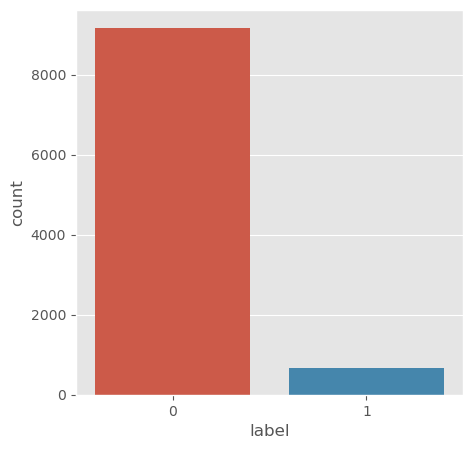

In [15]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = tweet_df)

Text(0.5, 1.0, 'Distribution of sentiments')

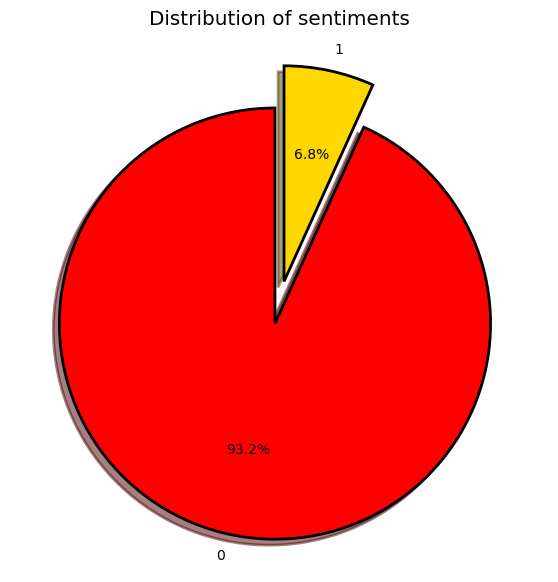

In [16]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_df['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [17]:
non_hate_tweets = tweet_df[tweet_df.label == 0]
non_hate_tweets.head()

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday majesty
3,4,0,model love u take u time ur
4,5,0,factsguide society motivation


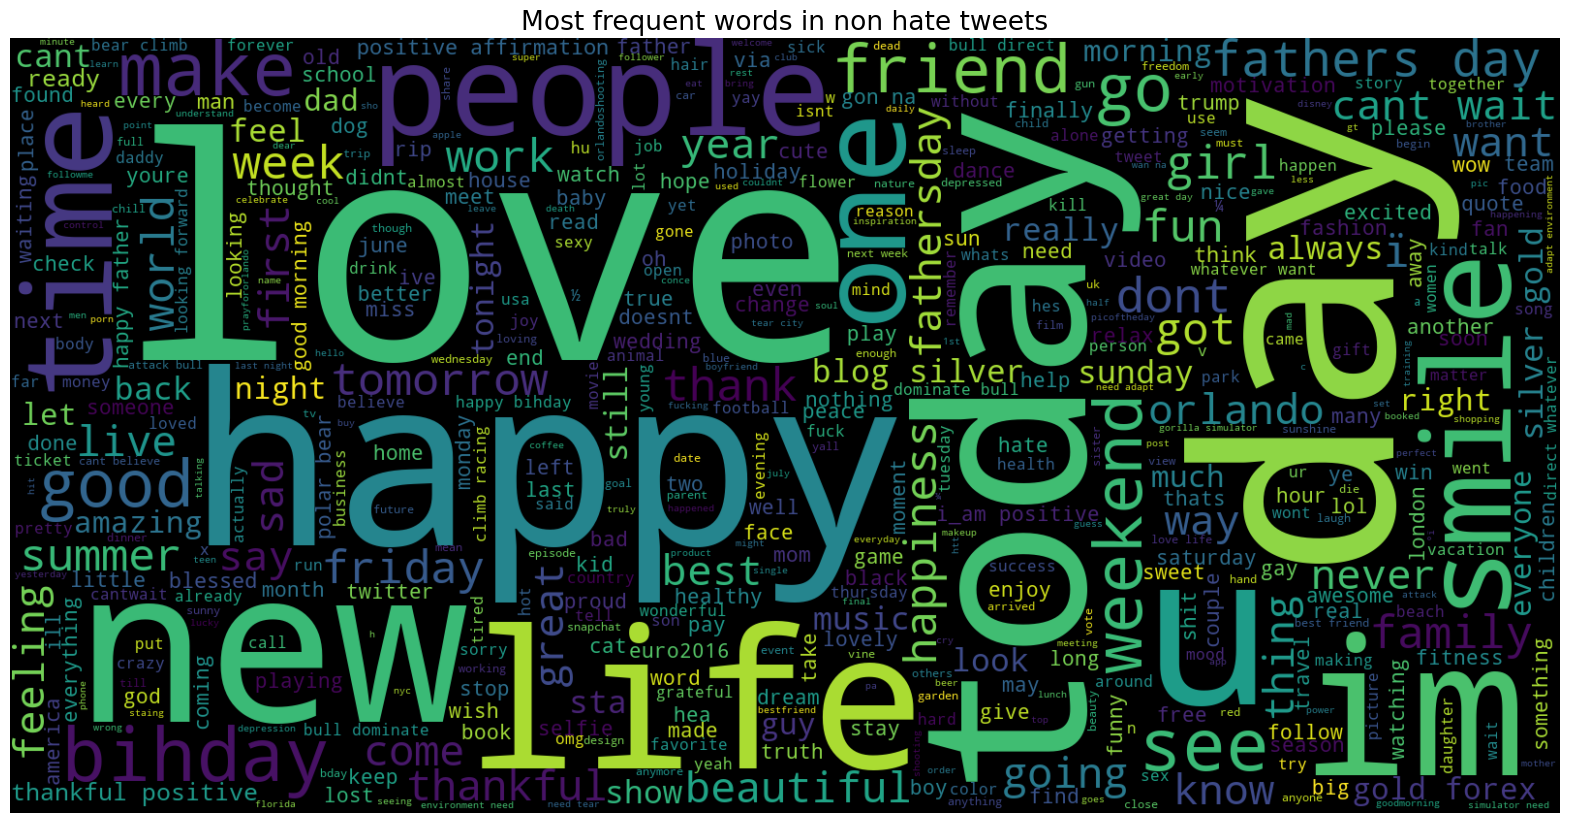

In [18]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non hate tweets', fontsize = 19)
plt.show()

In [19]:
neg_tweets = tweet_df[tweet_df.label == 1]
neg_tweets.head()

,id,label,tweet
13,14,1,cnn calls michigan middle school build wall ch...
14,15,1,comment australia opkillingbay seashepherd hel...
17,18,1,retweet agree
23,24,1,lumpy says prove lumpy
34,35,1,unbelievable 21st century wed need something l...


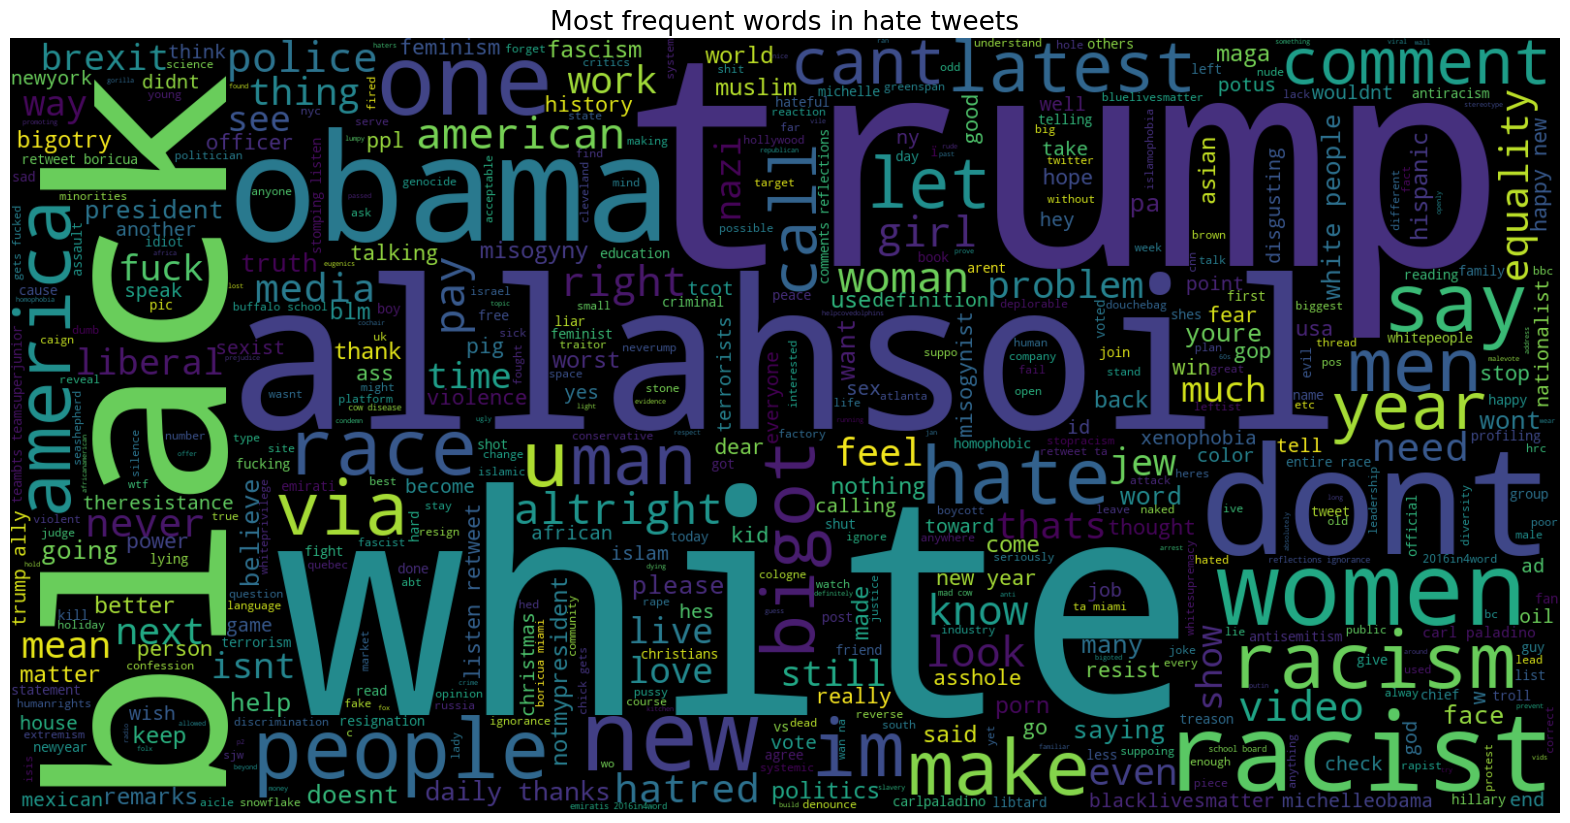

In [20]:
text = ' '.join([word for word in neg_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize = 19)
plt.show()

In [21]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

In [22]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 79561

First 20 features: 
['001', '00h30', '01', '01 4995', '01 7900', '01 croatia', '01 may', '01 shopalyssas', '0115', '0115 8599968', '0161', '0161 manny', '01926889917', '02', '02 05', '02 academy', '02 animation', '02 may', '02 mm', '0266808099']


In [23]:
vect = TfidfVectorizer(ngram_range=(1,3)).fit(tweet_df['tweet'])

In [24]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 135042

First 20 features: 
['001', '00h30', '01', '01 4995', '01 4995 rustic', '01 7900', '01 7900 shopalyssas', '01 croatia', '01 croatia happy', '01 may', '01 may blog', '01 shopalyssas', '01 shopalyssas upsideofflorida', '0115', '0115 8599968', '0115 8599968 rev', '0161', '0161 manny', '0161 manny map', '01926889917']


## Model Building

In [25]:
X = tweet_df['tweet']
Y = tweet_df['label']
X = vect.transform(X)

X.shape

(9825, 135042)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (7860, 135042)
Size of y_train: (7860,)
Size of x_test:  (1965, 135042)
Size of y_test:  (1965,)


# Logistic regression

In [28]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
acc0 = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(acc0*100))

Test accuarcy: 92.16%


In [29]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

[[1811    0]
 [ 154    0]]


              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1811
           1       0.00      0.00      0.00       154

    accuracy                           0.92      1965
   macro avg       0.46      0.50      0.48      1965
weighted avg       0.85      0.92      0.88      1965



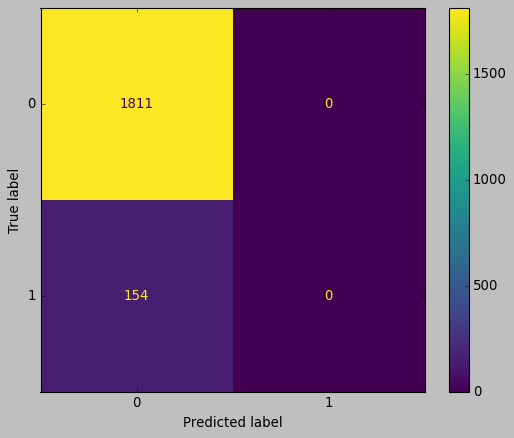

In [30]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

In [31]:
# from sklearn.model_selection import GridSearchCV
# import warnings
# warnings.filterwarnings('ignore')

In [32]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.94
Best parameters:  {'C': 100, 'solver': 'newton-cg'}


In [33]:
y_pred = grid.predict(x_test)

In [34]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 93.33%


In [35]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1811    0]
 [ 131   23]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1811
           1       1.00      0.15      0.26       154

    accuracy                           0.93      1965
   macro avg       0.97      0.57      0.61      1965
weighted avg       0.94      0.93      0.91      1965



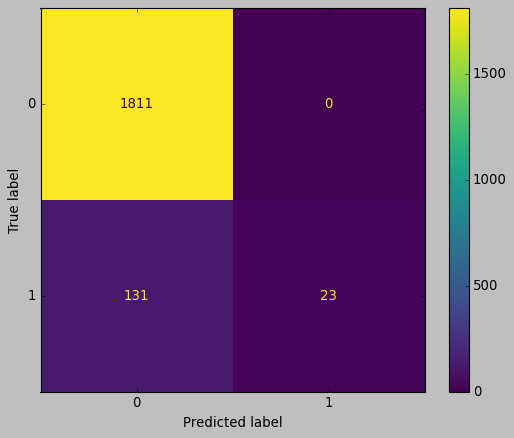

In [36]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

# RANDOM FOREST

In [37]:
# Random Forest

#X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
rf=RandomForestClassifier()
rf.fit(x_train,y_train)
y_preds = rf.predict(x_test)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1*100)

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1811
           1       0.96      0.16      0.27       154

    accuracy                           0.93      1965
   macro avg       0.95      0.58      0.62      1965
weighted avg       0.94      0.93      0.91      1965

Random Forest, Accuracy Score: 93.33333333333333


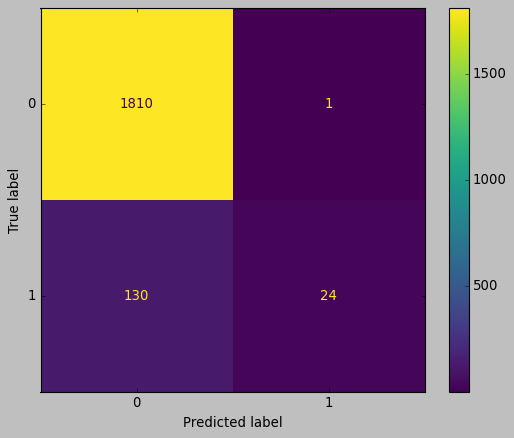

In [38]:
style.use('classic')
cm_rf = confusion_matrix(y_test, y_preds, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot()

In [39]:
estimator = RandomForestClassifier()
estimator.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [40]:
# Hyperparameter tuning

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(x_train, y_train)

print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.94
Best parameters:  {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 10}


In [74]:
y_pred = grid.predict(x_test)

ranfor_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(ranfor_acc*100))

Test accuracy: 94.43%


In [42]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1810    1]
 [ 138   16]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       0.94      0.10      0.19       154

    accuracy                           0.93      1965
   macro avg       0.94      0.55      0.58      1965
weighted avg       0.93      0.93      0.90      1965



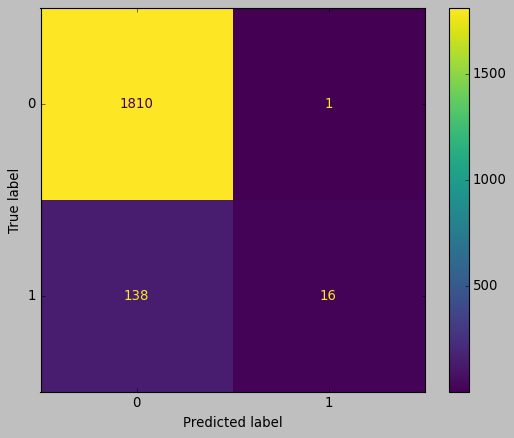

In [43]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

# NAIVE BAYES

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1811
           1       0.40      0.41      0.41       154

    accuracy                           0.91      1965
   macro avg       0.68      0.68      0.68      1965
weighted avg       0.91      0.91      0.91      1965

Naive Bayes, Accuracy Score: 90.63613231552164


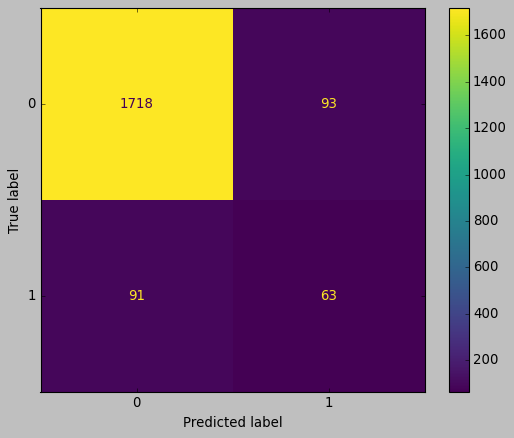

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X.toarray(), Y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(x_train,y_train)
y_preds = nb.predict(x_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2*100)

style.use('classic')
cm_nb = confusion_matrix(y_test, y_preds, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb.classes_)
disp.plot()

In [45]:
estimator = GaussianNB()
estimator.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [46]:
param_grid = {'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7]],
              'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
nb = GaussianNB()
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

{'priors': None, 'var_smoothing': 1e-09}


In [47]:
y_pred = grid.predict(x_test)

naibay_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(naibay_acc*100))

Test accuracy: 92.93%


In [48]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1810    1]
 [ 138   16]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       0.94      0.10      0.19       154

    accuracy                           0.93      1965
   macro avg       0.94      0.55      0.58      1965
weighted avg       0.93      0.93      0.90      1965



# SVM

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       1.00      0.14      0.24       154

    accuracy                           0.93      1965
   macro avg       0.97      0.57      0.60      1965
weighted avg       0.94      0.93      0.91      1965

SVM, Accuracy Score: 0.9323155216284987


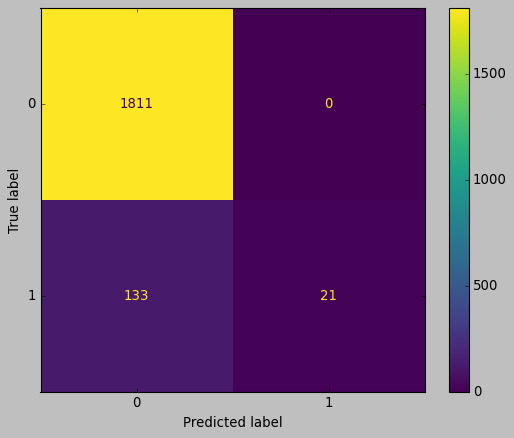

In [77]:
svm =LinearSVC(random_state=20)
svm.fit(x_train,y_train)
y_preds = svm.predict(x_test)
acc3=accuracy_score(y_test,y_preds)
report = classification_report(y_test, y_preds)
print(report)
print("SVM, Accuracy Score:" , acc3)

style.use('classic')
cm_svm = confusion_matrix(y_test, y_preds, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)
disp.plot()

In [51]:
estimator = LinearSVC()
estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [52]:
svm = LinearSVC()

# Define the hyperparameter grid
param_grid = {'C': [0.1, 1, 10],
              'loss': ['hinge', 'squared_hinge'],
              'multi_class': ['ovr', 'crammer_singer']}

# Create the grid search object
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 10, 'loss': 'hinge', 'multi_class': 'crammer_singer'}


In [78]:
y_pred = grid.predict(x_test)

svm_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(svm_acc))

Test accuracy: 0.94%


In [54]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1810    1]
 [ 138   16]]


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1811
           1       0.94      0.10      0.19       154

    accuracy                           0.93      1965
   macro avg       0.94      0.55      0.58      1965
weighted avg       0.93      0.93      0.90      1965



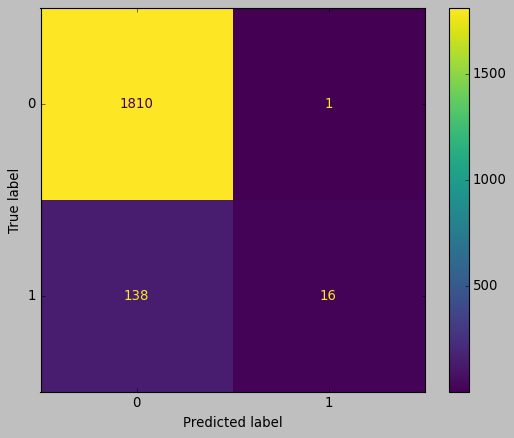

In [55]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

# XGBoost

In [38]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [39]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc' )

In [40]:
xgb_model = xgb_model.fit(x_train, y_train)
xgb_predictions=xgb_model.predict(x_test)
xgb_acc = accuracy_score(xgb_predictions, y_test)
print('Test accuracy: ',xgb_acc*100)
print(confusion_matrix(y_test,xgb_predictions))
print (classification_report(y_test, xgb_predictions))

Test accuracy:  93.87242591662482
[[1850    3]
 [ 119   19]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1853
           1       0.86      0.14      0.24       138

    accuracy                           0.94      1991
   macro avg       0.90      0.57      0.60      1991
weighted avg       0.93      0.94      0.92      1991



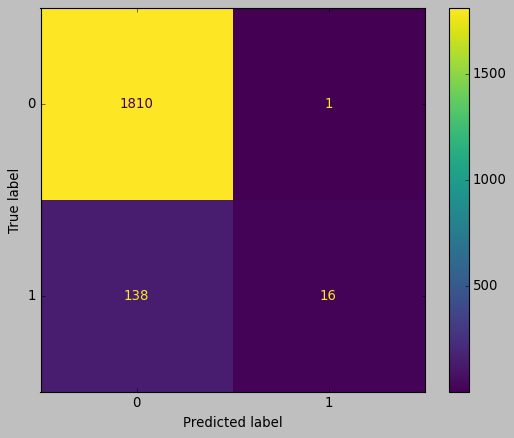

In [68]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_)
disp.plot()

In [41]:
# Convert the data into an XGBoost-compatible format
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

# Set up the parameters for the XGBoost model
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [42]:
# Create the grid search object
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [43]:
# Fit the grid search object to the training data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [55]:
# Print the best parameters and the best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_:.2f}')

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
preds = best_model.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, preds)
print('Test accuracy: ',accuracy)

Best parameters: {'colsample_bytree': 0.9, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.9}
Best score: 0.94
Test accuracy:  0.9412355600200905


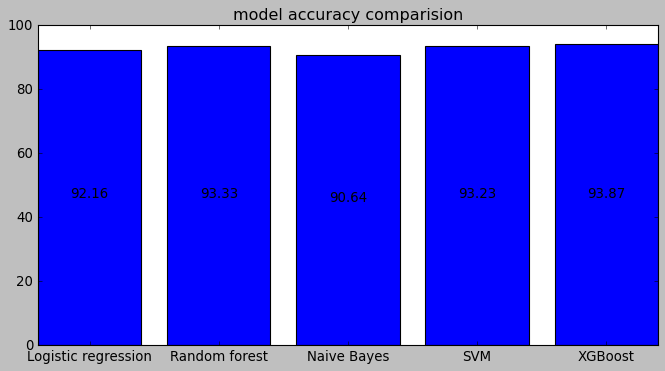

In [79]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
  
if __name__ == '__main__':
    
    # creating data on which bar chart will be plot
    x = ["Logistic regression", "Random forest", "Naive Bayes", "SVM", "XGBoost"]
      
    y = [round(acc0*100,2), round(acc1*100,2), round(acc2*100,2), round(acc3*100,2), round(xgb_acc*100,2)]
      
    # setting figure size by using figure() function 
    plt.figure(figsize = (10,5))
      
    # making the bar chart on the data
    plt.bar(x, y)
      
    # calling the function to add value labels
    addlabels(x, y)
      
    # giving title to the plot
    plt.title("model accuracy comparision")
      
    # visualizing the plot
    plt.show()

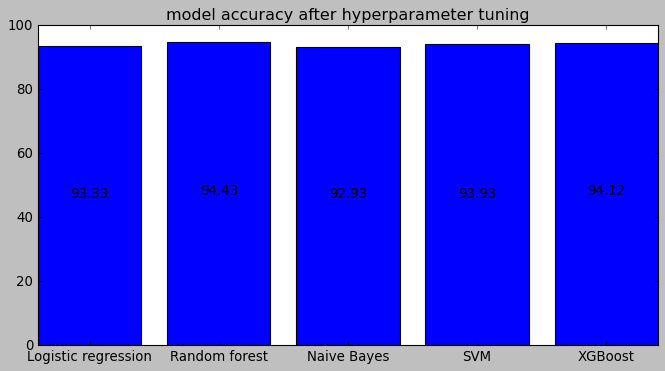

In [80]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
  
if __name__ == '__main__':
    
    # creating data on which bar chart will be plot
    x = ["Logistic regression", "Random forest", "Naive Bayes", "SVM", "XGBoost"]
      
    y = [round(logreg_acc*100,2), round(ranfor_acc*100,2), round(naibay_acc*100,2), round(svm_acc*100,2), round(accuracy*100,2)]
      
    # setting figure size by using figure() function 
    plt.figure(figsize = (10,5))
      
    # making the bar chart on the data
    plt.bar(x, y)
      
    # calling the function to add value labels
    addlabels(x, y)
      
    # giving title to the plot
    plt.title("model accuracy after hyperparameter tuning")
      
    # visualizing the plot
    plt.show()

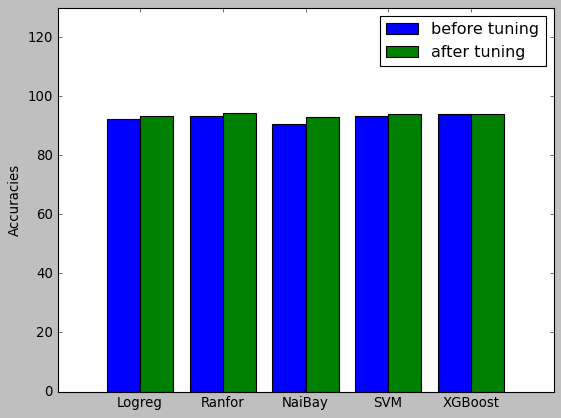

In [81]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ["Logreg", "Ranfor", "NaiBay", "SVM", "XGBoost"]
acc_before = [round(acc0*100,2), round(acc1*100,2), round(acc2*100,2), round(acc3*100,2), round(xgb_acc*100,2)]
acc_after = [round(logreg_acc*100,2), round(ranfor_acc*100,2), round(naibay_acc*100,2), round(svm_acc*100,2),round(accuracy*100,2)]

X_axis = np.arange(len(X))
plt.ylim(ymax=130)
  
plt.bar(X_axis - 0.2, acc_before, 0.4, label = 'before tuning')
plt.bar(X_axis + 0.2, acc_after, 0.4, label = 'after tuning')

plt.xticks(X_axis, X)
#plt.xlabel("Groups")
plt.ylabel("Accuracies")
#plt.title("Number of Students in each group")
plt.legend()
plt.show()